In [1]:
import numpy as np
from numpy import array
from numpy import savetxt
import math
from scipy.fft import dct
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
import IPython.display as ipd
import librosa
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import pathlib

In [2]:
#Cargas Audios
#Parámetros
sampling_rate = 4096
duration = 2

#Calcula número de muestras
num_muestras = sampling_rate*duration
num_muestras

#Vector de clases
clases_vec = [0,1]
emotion_vec = ["Other","Angry"]

In [3]:
#Carga Audios Entrenamiento (English)
#---------------------------------------------------------
#Carpeta con los audios de enojo (Angry)
trainAudioAngryPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Angry/train'
#Carpeta con los audios de felicidad (Happy)
trainAudioHappyPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Happy/train'
#Carpeta con los audios neutrales (Neutral)
trainAudioNeutralPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Neutral/train'
#Carpeta con los audios de tristeza (Sad)
trainAudioSadPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Sad/train'
#Carpeta con los audios de tristeza (Surprise)
trainAudioSurprisePath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Surprise/train'
#Carga Audios Prueba (English)
#---------------------------------------------------------
#Carpeta con los audios de enojo (Angry)
testAudioAngryPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Angry/test'
#Carpeta con los audios de felicidad (Happy)
testAudioHappyPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Happy/test'
#Carpeta con los audios neutrales (Neutral)
testAudioNeutralPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Neutral/test'
#Carpeta con los audios de tristeza (Sad)
testAudioSadPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Sad/test'
#Carpeta con los audios de tristeza (Surprise)
testAudioSurprisePath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Surprise/test'
#Carga Audios Evaluación (English)
#---------------------------------------------------------
#Carpeta con los audios de enojo (Angry)
evalAudioAngryPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Angry/evaluation'
#Carpeta con los audios de felicidad (Happy)
evalAudioHappyPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Happy/evaluation'
#Carpeta con los audios neutrales (Neutral)
evalAudioNeutralPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Neutral/evaluation'
#Carpeta con los audios de tristeza (Sad)
evalAudioSadPath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Sad/evaluation'
#Carpeta con los audios de tristeza (Surprise)
evalAudioSurprisePath = '../Dataset/ESD/Emotional_Speech_Dataset/English/Surprise/evaluation'



#Carga Audios Entrenamiento (Chinese)
#---------------------------------------------------------
#Carpeta con los audios de enojo (Angry)
trainAudioAngryPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Angry/train'
#Carpeta con los audios de felicidad (Happy)
trainAudioHappyPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Happy/train'
#Carpeta con los audios neutrales (Neutral)
trainAudioNeutralPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Neutral/train'
#Carpeta con los audios de tristeza (Sad)
trainAudioSadPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Sad/train'
#Carpeta con los audios de tristeza (Surprise)
trainAudioSurprisePathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Surprise/train'
#Carga Audios Prueba (Chinese)
#---------------------------------------------------------
#Carpeta con los audios de enojo (Angry)
testAudioAngryPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Angry/test'
#Carpeta con los audios de felicidad (Happy)
testAudioHappyPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Happy/test'
#Carpeta con los audios neutrales (Neutral)
testAudioNeutralPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Neutral/test'
#Carpeta con los audios de tristeza (Sad)
testAudioSadPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Sad/test'
#Carpeta con los audios de tristeza (Surprise)
testAudioSurprisePathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Surprise/test'
#Carga Audios Evaluación (Chinese)
#---------------------------------------------------------
#Carpeta con los audios de enojo (Angry)
evalAudioAngryPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Angry/evaluation'
#Carpeta con los audios de felicidad (Happy)
evalAudioHappyPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Happy/evaluation'
#Carpeta con los audios neutrales (Neutral)
evalAudioNeutralPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Neutral/evaluation'
#Carpeta con los audios de tristeza (Sad)
evalAudioSadPathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Sad/evaluation'
#Carpeta con los audios de tristeza (Surprise)
evalAudioSurprisePathC = '../Dataset/ESD/Emotional_Speech_Dataset/Chinese/Surprise/evaluation'

In [4]:
#Función para cargar audios de una carpeta
def loadAudio(pathAudio, label):
    #Encuentra los archivos con extensión .wav y los pone en una lista
    files = librosa.util.find_files(pathAudio, ext=['wav']) 
    #Convierte la lista en un arreglo numpy
    files = np.asarray(files)

    #Crea lista de audios vacía
    Audios = []

    #Lee los audios y los almacena en la lista de audios
    for archivo in files: 
        audio = librosa.load(archivo, sr=sampling_rate, mono=True, duration=duration)
        #calcula espectrograma
        spectrogram = np.abs(librosa.stft(audio[0], n_fft=512, hop_length=256))
        #calcula espectrograma en decibeles 
        spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
        
        #Calcula la energía máxima por columna de tiempo
        max_energy = np.empty(spectrogram_db.shape[1])
        for i in range(spectrogram_db.shape[1]):
            max_energy[i] = np.mean(spectrogram_db[:,i])
            
        #Guarda posición inicial de dato de muestro
        for i in range(1, spectrogram_db.shape[1]):
            diff_energy = abs(max_energy[i]-max_energy[i-1])
            if(diff_energy >= 5):
                #Número de columnas
                col = spectrogram_db.shape[1]
                #Muestras por columna
                muesXcol = int(num_muestras/col)
                #Posición inicial
                start_pos = (i * muesXcol)
                break
        
        #Lee audio nuevamente pero agregando 2 segundos
        audio = librosa.load(archivo, sr=sampling_rate, mono=True, duration=duration+2)     
        #Toma 2 segundos de audio a partir de donde empieza el sonido
        new_audio = audio[0][start_pos : start_pos+num_muestras]
        
        Audios.append(new_audio)
    
    #Crea nueva lista de audios con igual dimensiones
    Audios_equal_dim = []
    
    for audio in Audios:
        
        if audio.shape[0]<num_muestras:
            sample = np.append(audio,np.zeros(num_muestras-audio.shape[0]))
        else:
            sample = audio[0:num_muestras]
        
        #Calcula media y desviación estandar
        mean = np.mean(sample)
        sd = np.std(sample)
        #Calcula ruido blanco
        white_noise = np.random.normal(loc = mean, scale = abs(sd/50), size = num_muestras)
        
        #Concatena audio más ruido
        Audios_equal_dim.append(sample+white_noise)
            
    #Regresa audios
    return np.asarray(Audios_equal_dim), np.full(len(Audios), label)

In [5]:
#Carga Audios Entrenamiento
#---------------------------------------------------------
trainAudiosAngry, trainLabelAngry = loadAudio(trainAudioAngryPath, clases_vec[1])
trainAudiosAngryC, trainLabelAngryC = loadAudio(trainAudioAngryPathC, clases_vec[1])

trainAudiosHappy, trainLabelHappy = loadAudio(trainAudioHappyPath, clases_vec[0])
trainAudiosHappyC, trainLabelHappyC = loadAudio(trainAudioHappyPathC, clases_vec[0])
trainAudiosNeutral, trainLabelNeutral = loadAudio(trainAudioNeutralPath, clases_vec[0])
trainAudiosNeutralC, trainLabelNeutralC = loadAudio(trainAudioNeutralPathC, clases_vec[0])
trainAudiosSad, trainLabelSad = loadAudio(trainAudioSadPath, clases_vec[0])
trainAudiosSadC, trainLabelSadC = loadAudio(trainAudioSadPathC, clases_vec[0])
trainAudiosSurprise, trainLabelSurprise = loadAudio(trainAudioSurprisePath, clases_vec[0])
trainAudiosSurpriseC, trainLabelSurpriseC = loadAudio(trainAudioSurprisePathC, clases_vec[0])

#Carga Audios Prueba
#---------------------------------------------------------
testAudiosAngry, testLabelAngry = loadAudio(testAudioAngryPath, clases_vec[1])
testAudiosAngryC, testLabelAngryC = loadAudio(testAudioAngryPathC, clases_vec[1])

testAudiosHappy, testLabelHappy = loadAudio(testAudioHappyPath, clases_vec[0])
testAudiosHappyC, testLabelHappyC = loadAudio(testAudioHappyPathC, clases_vec[0])
testAudiosNeutral, testLabelNeutral = loadAudio(testAudioNeutralPath, clases_vec[0])
testAudiosNeutralC, testLabelNeutralC = loadAudio(testAudioNeutralPathC, clases_vec[0])
testAudiosSad, testLabelSad = loadAudio(testAudioSadPath, clases_vec[0])
testAudiosSadC, testLabelSadC = loadAudio(testAudioSadPathC, clases_vec[0])
testAudiosSurprise, testLabelSurprise = loadAudio(testAudioSurprisePath, clases_vec[0])
testAudiosSurpriseC, testLabelSurpriseC = loadAudio(testAudioSurprisePathC, clases_vec[0])

#Carga Audios Evaluación
#---------------------------------------------------------
evalAudiosAngry, evalLabelAngry = loadAudio(evalAudioAngryPath, clases_vec[1])
evalAudiosAngryC, evalLabelAngryC = loadAudio(evalAudioAngryPathC, clases_vec[1])

evalAudiosHappy, evalLabelHappy = loadAudio(evalAudioHappyPath, clases_vec[0])
evalAudiosHappyC, evalLabelHappyC = loadAudio(evalAudioHappyPathC, clases_vec[0])
evalAudiosNeutral, evalLabelNeutral = loadAudio(evalAudioNeutralPath, clases_vec[0])
evalAudiosNeutralC, evalLabelNeutralC = loadAudio(evalAudioNeutralPathC, clases_vec[0])
evalAudiosSad, evalLabelSad = loadAudio(evalAudioSadPath, clases_vec[0])
evalAudiosSadC, evalLabelSadC = loadAudio(evalAudioSadPathC, clases_vec[0])
evalAudiosSurprise, evalLabelSurprise = loadAudio(evalAudioSurprisePath, clases_vec[0])
evalAudiosSurpriseC, evalLabelSurpriseC = loadAudio(evalAudioSurprisePathC, clases_vec[0])

In [6]:
#Resumen de datos de entrenamiento
#---------------------------------------------------------
print('Audios de entrenamiento:')
print('Número de audios de enojo:\t', trainAudiosAngry.shape, "Etiqueta: ", trainLabelAngry[0])
print('Número de audios de enojoC:\t', trainAudiosAngryC.shape, "Etiqueta: ", trainLabelAngryC[0])
print('Total audios enojo: ',trainAudiosAngry.shape[0]+trainAudiosAngryC.shape[0])
print("\n")
print('Número de audios de felicidad:\t', trainAudiosHappy.shape, "Etiqueta: ", trainLabelHappy[0])
print('Número de audios de felicidadC:\t', trainAudiosHappyC.shape, "Etiqueta: ", trainLabelHappyC[0])
print('Número de audios neutrales:\t', trainAudiosNeutral.shape, "Etiqueta: ", trainLabelNeutral[0])
print('Número de audios neutralesC:\t', trainAudiosNeutralC.shape, "Etiqueta: ", trainLabelNeutralC[0])
print('Número de audios de tristeza:\t', trainAudiosSad.shape, "Etiqueta: ", trainLabelSad[0])
print('Número de audios de tristezaC:\t', trainAudiosSadC.shape, "Etiqueta: ", trainLabelSadC[0])
print('Número de audios de sorpresa:\t', trainAudiosSurprise.shape, "Etiqueta: ", trainLabelSurprise[0])
print('Número de audios de sorpresaC:\t', trainAudiosSurpriseC.shape, "Etiqueta: ", trainLabelSurpriseC[0])
#Resumen de datos de entrenamiento
#---------------------------------------------------------
print('\nAudios de prueba:')
print('Número de audios de enojo:\t', testAudiosAngry.shape, "Etiqueta: ", testLabelAngry[0])
print('Número de audios de enojoC:\t', testAudiosAngryC.shape, "Etiqueta: ", testLabelAngryC[0])
print('Total audios enojo: ',testAudiosAngry.shape[0]+testAudiosAngryC.shape[0])
print("\n")
print('Número de audios de felicidad:\t', testAudiosHappy.shape, "Etiqueta: ", testLabelHappy[0])
print('Número de audios de felicidadC:\t', testAudiosHappyC.shape, "Etiqueta: ", testLabelHappyC[0])
print('Número de audios neutrales:\t', testAudiosNeutral.shape, "Etiqueta: ", testLabelNeutral[0])
print('Número de audios neutralesC:\t', testAudiosNeutralC.shape, "Etiqueta: ", testLabelNeutralC[0])
print('Número de audios de tristeza:\t', testAudiosSad.shape, "Etiqueta: ", testLabelSad[0])
print('Número de audios de tristezaC:\t', testAudiosSadC.shape, "Etiqueta: ", testLabelSadC[0])
print('Número de audios de sorpresa:\t', testAudiosSurprise.shape, "Etiqueta: ", testLabelSurprise[0])
print('Número de audios de sorpresaC:\t', testAudiosSurpriseC.shape, "Etiqueta: ", testLabelSurpriseC[0])

#Resumen de datos de entrenamiento
#---------------------------------------------------------
print('\nAudios de evaluación:')
print('Número de audios de enojo:\t', evalAudiosAngry.shape, "Etiqueta: ", evalLabelAngry[0])
print('Número de audios de enojoC:\t', evalAudiosAngryC.shape, "Etiqueta: ", evalLabelAngryC[0])
print('Total audios enojo: ',evalAudiosAngry.shape[0]+evalAudiosAngryC.shape[0])
print("\n")
print('Número de audios de felicidad:\t', evalAudiosHappy.shape, "Etiqueta: ", evalLabelHappy[0])
print('Número de audios de felicidadC:\t', evalAudiosHappyC.shape, "Etiqueta: ", evalLabelHappyC[0])
print('Número de audios neutrales:\t', evalAudiosNeutral.shape, "Etiqueta: ", evalLabelNeutral[0])
print('Número de audios neutralesC:\t', evalAudiosNeutralC.shape, "Etiqueta: ", evalLabelNeutralC[0])
print('Número de audios de tristeza:\t', evalAudiosSad.shape, "Etiqueta: ", evalLabelSad[0])
print('Número de audios de tristezaC:\t', evalAudiosSadC.shape, "Etiqueta: ", evalLabelSadC[0])
print('Número de audios de sorpresa:\t', evalAudiosSurprise.shape, "Etiqueta: ", evalLabelSurprise[0])
print('Número de audios de sorpresaC:\t', evalAudiosSurpriseC.shape, "Etiqueta: ", evalLabelSurpriseC[0])

Audios de entrenamiento:
Número de audios de enojo:	 (3000, 8192) Etiqueta:  1
Número de audios de enojoC:	 (3000, 8192) Etiqueta:  1
Total audios enojo:  6000


Número de audios de felicidad:	 (3000, 8192) Etiqueta:  0
Número de audios de felicidadC:	 (3008, 8192) Etiqueta:  0
Número de audios neutrales:	 (3000, 8192) Etiqueta:  0
Número de audios neutralesC:	 (3000, 8192) Etiqueta:  0
Número de audios de tristeza:	 (3000, 8192) Etiqueta:  0
Número de audios de tristezaC:	 (3000, 8192) Etiqueta:  0
Número de audios de sorpresa:	 (3001, 8192) Etiqueta:  0
Número de audios de sorpresaC:	 (3000, 8192) Etiqueta:  0

Audios de prueba:
Número de audios de enojo:	 (300, 8192) Etiqueta:  1
Número de audios de enojoC:	 (300, 8192) Etiqueta:  1
Total audios enojo:  600


Número de audios de felicidad:	 (300, 8192) Etiqueta:  0
Número de audios de felicidadC:	 (300, 8192) Etiqueta:  0
Número de audios neutrales:	 (300, 8192) Etiqueta:  0
Número de audios neutralesC:	 (300, 8192) Etiqueta:  0
Núm

In [7]:
#Función para elegir cierto número de muestras de audio y etiquetas aleatoriamente
def random_samples(num_index, num_total, audios, labels):
    random_index = np.random.choice(num_index, num_total//8, replace=False)
    random_audios = audios[random_index]
    random_labels = labels[random_index]
    return random_audios, random_labels

In [8]:
#Numero total de audios de enojo en entrenamiento, prueba y evaluación 
num_aud_angry_train = trainAudiosAngry.shape[0]+trainAudiosAngryC.shape[0]
num_aud_angry_test = testAudiosAngry.shape[0]+testAudiosAngryC.shape[0]
num_aud_angry_eval = evalAudiosAngry.shape[0]+evalAudiosAngryC.shape[0]

#Toma aleatoriamente "num_audios_angry_train" muestras para cada emoción distinta al enojo
trainAudiosHappy, trainLabelHappy = random_samples(trainAudiosHappy.shape[0], num_aud_angry_train, trainAudiosHappy, trainLabelHappy)
trainAudiosHappyC, trainLabelHappyC = random_samples(trainAudiosHappyC.shape[0], num_aud_angry_train, trainAudiosHappyC, trainLabelHappyC)
trainAudiosNeutral, trainLabelNeutral = random_samples(trainAudiosNeutral.shape[0], num_aud_angry_train, trainAudiosNeutral, trainLabelNeutral)
trainAudiosNeutralC, trainLabelNeutralC = random_samples(trainAudiosNeutralC.shape[0], num_aud_angry_train, trainAudiosNeutralC, trainLabelNeutralC)
trainAudiosSad, trainLabelSad = random_samples(trainAudiosSad.shape[0], num_aud_angry_train, trainAudiosSad, trainLabelSad)
trainAudiosSadC, trainLabelSadC = random_samples(trainAudiosSadC.shape[0], num_aud_angry_train, trainAudiosSadC, trainLabelSadC)
trainAudiosSurprise, trainLabelSurprise = random_samples(trainAudiosSurprise.shape[0], num_aud_angry_train, trainAudiosSurprise, trainLabelSurprise)
trainAudiosSurpriseC, trainLabelSurpriseC = random_samples(trainAudiosSurpriseC.shape[0], num_aud_angry_train, trainAudiosSurpriseC, trainLabelSurpriseC)

#Toma aleatoriamente "num_audios_angry_test" muestras para cada emoción distinta al enojo
testAudiosHappy, testLabelHappy = random_samples(testAudiosHappy.shape[0], num_aud_angry_test, testAudiosHappy, testLabelHappy)
testAudiosHappyC, testLabelHappyC = random_samples(testAudiosHappyC.shape[0], num_aud_angry_test, testAudiosHappyC, testLabelHappyC)
testAudiosNeutral, testLabelNeutral = random_samples(testAudiosNeutral.shape[0], num_aud_angry_test, testAudiosNeutral, testLabelNeutral)
testAudiosNeutralC, testLabelNeutralC = random_samples(testAudiosNeutralC.shape[0], num_aud_angry_test, testAudiosNeutralC, testLabelNeutralC)
testAudiosSad, testLabelSad = random_samples(testAudiosSad.shape[0], num_aud_angry_test, testAudiosSad, testLabelSad)
testAudiosSadC, testLabelSadC = random_samples(testAudiosSadC.shape[0], num_aud_angry_test, testAudiosSadC, testLabelSadC)
testAudiosSurprise, testLabelSurprise = random_samples(testAudiosSurprise.shape[0], num_aud_angry_test, testAudiosSurprise, testLabelSurprise)
testAudiosSurpriseC, testLabelSurpriseC = random_samples(testAudiosSurpriseC.shape[0], num_aud_angry_test, testAudiosSurpriseC, testLabelSurpriseC)

#Toma aleatoriamente "num_audios_angry_eval" muestras para cada emoción distinta al enojo
evalAudiosHappy, evalLabelHappy = random_samples(evalAudiosHappy.shape[0], num_aud_angry_eval, evalAudiosHappy, evalLabelHappy)
evalAudiosHappyC, evalLabelHappyC = random_samples(evalAudiosHappyC.shape[0], num_aud_angry_eval, evalAudiosHappyC, evalLabelHappyC)
evalAudiosNeutral, evalLabelNeutral = random_samples(evalAudiosNeutral.shape[0], num_aud_angry_eval, evalAudiosNeutral, evalLabelNeutral)
evalAudiosNeutralC, evalLabelNeutralC = random_samples(evalAudiosNeutralC.shape[0], num_aud_angry_eval, evalAudiosNeutralC, evalLabelNeutralC)
evalAudiosSad, evalLabelSad = random_samples(evalAudiosSad.shape[0], num_aud_angry_eval, evalAudiosSad, evalLabelSad)
evalAudiosSadC, evalLabelSadC = random_samples(evalAudiosSadC.shape[0], num_aud_angry_eval, evalAudiosSadC, evalLabelSadC)
evalAudiosSurprise, evalLabelSurprise = random_samples(evalAudiosSurprise.shape[0], num_aud_angry_eval, evalAudiosSurprise, evalLabelSurprise)
evalAudiosSurpriseC, evalLabelSurpriseC = random_samples(evalAudiosSurpriseC.shape[0], num_aud_angry_eval, evalAudiosSurpriseC, evalLabelSurpriseC)

In [9]:
#Función para concatenar audios y etiquetas
def concatenaAudios(audio1, audio2, label1, label2):
    audio1 = np.concatenate([audio1, audio2])
    label1 = np.concatenate([label1, label2])
    return audio1, label1

In [10]:
#Concatena audios y etiquetas de entrenamiento
#---------------------------------------------------------
trainAudios, trainLabels = concatenaAudios(trainAudiosAngry, trainAudiosAngryC, trainLabelAngry, trainLabelAngryC)
trainAudios, trainLabels = concatenaAudios(trainAudios, trainAudiosHappy, trainLabels, trainLabelHappy)
trainAudios, trainLabels = concatenaAudios(trainAudios, trainAudiosHappyC, trainLabels, trainLabelHappyC)
trainAudios, trainLabels = concatenaAudios(trainAudios, trainAudiosNeutral, trainLabels, trainLabelNeutral)
trainAudios, trainLabels = concatenaAudios(trainAudios, trainAudiosNeutralC, trainLabels, trainLabelNeutralC)
trainAudios, trainLabels = concatenaAudios(trainAudios, trainAudiosSad, trainLabels, trainLabelSad)
trainAudios, trainLabels = concatenaAudios(trainAudios, trainAudiosSadC, trainLabels, trainLabelSadC)
trainAudios, trainLabels = concatenaAudios(trainAudios, trainAudiosSurprise, trainLabels, trainLabelSurprise)
trainAudios, trainLabels = concatenaAudios(trainAudios, trainAudiosSurpriseC, trainLabels, trainLabelSurpriseC)

#Concatena audios y etiquetas de prueba
#---------------------------------------------------------
testAudios, testLabels = concatenaAudios(testAudiosAngry, testAudiosAngryC, testLabelAngry, testLabelAngryC)
testAudios, testLabels = concatenaAudios(testAudios, testAudiosHappy, testLabels, testLabelHappy)
testAudios, testLabels = concatenaAudios(testAudios, testAudiosHappyC, testLabels, testLabelHappyC)
testAudios, testLabels = concatenaAudios(testAudios, testAudiosNeutral, testLabels, testLabelNeutral)
testAudios, testLabels = concatenaAudios(testAudios, testAudiosNeutralC, testLabels, testLabelNeutralC)
testAudios, testLabels = concatenaAudios(testAudios, testAudiosSad, testLabels, testLabelSad)
testAudios, testLabels = concatenaAudios(testAudios, testAudiosSadC, testLabels, testLabelSadC)
testAudios, testLabels = concatenaAudios(testAudios, testAudiosSurprise, testLabels, testLabelSurprise)
testAudios, testLabels = concatenaAudios(testAudios, testAudiosSurpriseC, testLabels, testLabelSurpriseC)

#Concatena audios y etiquetas de evaluación
#---------------------------------------------------------
evalAudios, evalLabels = concatenaAudios(evalAudiosAngry, evalAudiosAngryC, evalLabelAngry, evalLabelAngryC)
evalAudios, evalLabels = concatenaAudios(evalAudios, evalAudiosHappy, evalLabels, evalLabelHappy)
evalAudios, evalLabels = concatenaAudios(evalAudios, evalAudiosHappyC, evalLabels, evalLabelHappyC)
evalAudios, evalLabels = concatenaAudios(evalAudios, evalAudiosNeutral, evalLabels, evalLabelNeutral)
evalAudios, evalLabels = concatenaAudios(evalAudios, evalAudiosNeutralC, evalLabels, evalLabelNeutralC)
evalAudios, evalLabels = concatenaAudios(evalAudios, evalAudiosSad, evalLabels, evalLabelSad)
evalAudios, evalLabels = concatenaAudios(evalAudios, evalAudiosSadC, evalLabels, evalLabelSadC)
evalAudios, evalLabels = concatenaAudios(evalAudios, evalAudiosSurprise, evalLabels, evalLabelSurprise)
evalAudios, evalLabels = concatenaAudios(evalAudios, evalAudiosSurpriseC, evalLabels, evalLabelSurpriseC)

In [11]:
#Resumen de audios
print('Número de audios de entrenamiento: ', trainAudios.shape, "Número de etiquetaa: ", trainLabels.shape)
print('Número de audios de prueba: ', testAudios.shape, "Número de etiqueta: ", testLabels.shape)
print('Número de audios evaluación: ', evalAudios.shape, "Número de etiqueta: ", evalLabels.shape)

Número de audios de entrenamiento:  (12000, 8192) Número de etiquetaa:  (12000,)
Número de audios de prueba:  (1200, 8192) Número de etiqueta:  (1200,)
Número de audios evaluación:  (800, 8192) Número de etiqueta:  (800,)


In [12]:
#Parámetros para calcular espectrograma
#-------------------------------------
#Cantidad de datos por audio
Size_data = num_muestras
#Tamaño de la ventana
Size_win = 256
#Tamaño de offset
Size_off = 128
#Número total de ventaneos
total_win_num = int(((Size_data-Size_win)/Size_off)+1)
total_win_num

#Parámetros para calcular MFCCs
#------------------------------
#Frecuencia mínima y máxima
frec_min = 20
frec_max = sampling_rate/2
#numero de bandas de Mel
Mel_bands = 20

In [13]:
#Función para calcular un filtro triangular
def triangular_fun(lower_lim, medium_lim, upper_lim, points_num):
    #Crea vector de coeficientes
    coefficients = np.zeros(points_num)
    #Calcula coeficientes
    for j in range(points_num):
        
        if j>=lower_lim and j<=medium_lim:
            coefficients[j] = (j - lower_lim) / (medium_lim - lower_lim)
        elif j>medium_lim and j<=upper_lim:
            coefficients[j] = (upper_lim - j) / (upper_lim - medium_lim)
        else: 
            coefficients[j] = 0
    #Regresa coeficientes
    return coefficients

def triangular_filter_mat(frec_min, frec_max, Mel_bands):
    #numero de límites de bandas
    Mel_num_limits = Mel_bands+2
    #Frecuencia mínima y máxima en Mels
    frec_min_mel = 2595 * np.log10(1 + frec_min / 700)
    frec_max_mel = 2595 * np.log10(1 + frec_max / 700)
    #Tamaño de límite de separación de bandas en Mels
    separation_mel = (frec_max_mel-frec_min_mel)/(Mel_num_limits-1)
    
    #Crea vecor de límites de bandas mel
    mel_limits = np.zeros(Mel_num_limits)
    #Crea vector de límites equidistantes en Mels
    mel_limits[0] = frec_min_mel
    for i in range(1,Mel_num_limits):
        mel_limits[i] = mel_limits[i-1]+separation_mel
    
    #Crea vecor de límites de bandas en Hertz
    Hz_limits = np.zeros(Mel_num_limits)
    #Conversión de límites de Mel a Hertz
    for i in range(Mel_num_limits):
        Hz_limits[i] = 700 * (10**(mel_limits[i]/ 2595) - 1)
        
    #Crea vecor de límites de bandas en FFT bins
    FFT_bins = np.zeros(Mel_num_limits)
    #Cambia valores de frcuencia (Hertz) por valores al FFT bin más cercano, 
    for i in range(Mel_num_limits):
        FFT_bins[i] = math.floor((Size_win//2+1)*Hz_limits[i]/frec_max)
    FFT_bins[Mel_num_limits-1] = Size_win//2
    
    #Define matriz de filtros triangulares
    Trian_mat= np.zeros((Mel_bands, Size_win//2+1))
    #Calula banco de filtros tringulares
    for i in range(2,Mel_num_limits):
        trian_filter = triangular_fun(FFT_bins[i-2], FFT_bins[i-1], FFT_bins[i], Size_win//2+1)
        Trian_mat[i-2,:] = trian_filter
    
    return Trian_mat

#Preénfasis
def preemphasis(signal, coeff=0.97):
    return np.append(signal[0], signal[1:] - coeff * signal[:-1])

#Ventaneo
def windowing(Hamming_window, preemphasized_signal):
    #Define matriz de ventaneos
    Win_mat= np.zeros((Size_win, total_win_num))

    #Ciclo para realizar ventaneo
    cont = 0
    for i in range(total_win_num):
        for j in range(Size_win):
            Win_mat[j][i] = Hamming_window[j]*preemphasized_signal[cont]
            cont = cont+1
        cont = cont-(Size_win-Size_off)
    
    return Win_mat

#fft
def fft_mat(Win_mat):
    #Define matriz de espectrograma
    FFT_mat= np.zeros((1+Size_win//2, total_win_num))
    #Ciclo para realizar FFT por ventana
    for i in range(total_win_num):
        FFT = abs(np.fft.fft(Win_mat[:,i], n = Size_win))
        FFT_mat[:,i] = FFT[0:1+Size_win//2]
    
    return FFT_mat

#Crea ventana Hamming con tamaño Size_win
Hamming_window = np.zeros(Size_win)
for i in range(Size_win):
    Hamming_window[i] = 0.53836-0.46164*(np.cos((2*np.pi*i)/(Size_win-1)));

In [14]:
#Función para calcular MFCCs
def calculoMFCCs(Audios):
    
    number = 1 #Inicializa numero de imagen
    mfccs = [] #Inicializa lista vacía de mfccs
    
    #Caucula Filtros triangulares
    Trian_mat = triangular_filter_mat(frec_min, frec_max, Mel_bands) 
    
    #Ciclo for para calcular MFCCs de cada audio
    for audio in Audios:
        #Espectrograma
        #------------------------------------------------------------------------
        #Preénfasis
        preemphasized_signal = preemphasis(audio)
        #Ventaneo
        Win_mat = windowing(Hamming_window, preemphasized_signal)
        #Fast Fourier Transform (FFT)
        FFT_mat = fft_mat(Win_mat)
        #Aplica banco de filtros triangulares a espectrograma
        Mel_mat = np.dot(Trian_mat, FFT_mat)
        #Aplica transformación logarítmita para escala más adecuada
        Mel_mat_log = 13*np.log(Mel_mat)
        #Aplica transformada de coseno discreta (DCT)
        mfcc = dct(Mel_mat_log, type=2, axis=0, norm='ortho')[:Mel_bands]
     
        #Agrega MFCC resultante a lista
        mfccs.append(mfcc)
        
    return np.asarray(mfccs)

In [15]:
#Calcula MFCCs de entrenamiento
trainMFCCs = calculoMFCCs(trainAudios)
#Calcula MFCCs de prueba
testMFCCs = calculoMFCCs(testAudios)
#Calcula MFCCs de evaluación
evalMFCCs = calculoMFCCs(evalAudios)

In [16]:
#Dimensiones de MFCCs
print('Las dimenciones de los MFCCs de entrenamiento son:\t', trainMFCCs.shape)
print('Las dimenciones de los MFCCs de prueba son:\t\t', testMFCCs.shape)
print('Las dimenciones de los MFCCs de evaluación son:\t\t', evalMFCCs.shape)

#Valor máximo en el arreglo de MFCCs
print('\nEl valor máximo de los MFCCs son: ', np.amax(trainMFCCs))
#Valor mínimo en el arreglo de MFCCs
print('El valor mínimo de los MFCCs son: ', np.amin(trainMFCCs))

Las dimenciones de los MFCCs de entrenamiento son:	 (12000, 20, 63)
Las dimenciones de los MFCCs de prueba son:		 (1200, 20, 63)
Las dimenciones de los MFCCs de evaluación son:		 (800, 20, 63)

El valor máximo de los MFCCs son:  113.4184711977475
El valor mínimo de los MFCCs son:  -340.7101255734138


In [23]:
# # Modelo SqueezeNet para Clasificación de Emociones
# 

#%% [code]
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, GlobalAveragePooling2D, 
                                     Dense, Input, concatenate, Dropout, BatchNormalization, 
                                     ZeroPadding2D, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, roc_auc_score
import numpy as np
from tensorflow.keras.layers import ZeroPadding2D




def improved_fire_module(x, squeeze_filters, expand_filters, use_batchnorm=True):
    # Capa de squeeze
    squeeze = Conv2D(squeeze_filters, (1,1), padding='valid')(x)
    if use_batchnorm:
        squeeze = BatchNormalization()(squeeze)
    squeeze = Activation('relu')(squeeze)
    
    # Expansión con 1x1
    expand_1x1 = Conv2D(expand_filters, (1,1), padding='valid')(squeeze)
    if use_batchnorm:
        expand_1x1 = BatchNormalization()(expand_1x1)
    expand_1x1 = Activation('relu')(expand_1x1)
    
    # Expansión con 3x3
    expand_3x3 = Conv2D(expand_filters, (3,3), padding='same')(squeeze)
    if use_batchnorm:
        expand_3x3 = BatchNormalization()(expand_3x3)
    expand_3x3 = Activation('relu')(expand_3x3)
    
    # Concatenar las expansiones
    return concatenate([expand_1x1, expand_3x3], axis=-1)

def improved_build_squeezenet(input_shape):
    inputs = Input(shape=input_shape)
    
    # ZeroPadding para mantener proporciones adecuadas
    x = ZeroPadding2D(((6, 6), (1, 1)))(inputs)
    
    # Convertir de 1 canal a 3 canales
    x = Conv2D(3, (1,1), padding='same')(x)
    
    # Primer bloque: Convolución inicial seguida de BatchNorm, activación y MaxPooling
    x = Conv2D(96, (7,7), strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
    
    # Bloques de Fire Modules
    x = improved_fire_module(x, squeeze_filters=16, expand_filters=64)
    x = improved_fire_module(x, squeeze_filters=16, expand_filters=64)
    x = improved_fire_module(x, squeeze_filters=32, expand_filters=128)
    
    # Pooling intermedio para reducir dimensiones
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
    
    x = improved_fire_module(x, squeeze_filters=32, expand_filters=128)
    x = improved_fire_module(x, squeeze_filters=48, expand_filters=192)
    x = improved_fire_module(x, squeeze_filters=48, expand_filters=192)
    x = improved_fire_module(x, squeeze_filters=64, expand_filters=256)
    
    # Dropout para evitar sobreajuste
    x = Dropout(0.5)(x)
    
    # Última convolución para reducción a un mapa de características,
    # seguida de BatchNorm, activación y Global Average Pooling
    x = Conv2D(1, (1,1), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    
    # Capa de salida con 2 neuronas para clasificación (softmax)
    outputs = Dense(2, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model



In [27]:
#TRAIN

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
# Se utiliza la forma de los MFCCs de entrenamiento (por ejemplo, (20,63,1))
squeezenet_model = improved_build_squeezenet((trainMFCCs.shape[1], trainMFCCs.shape[2], 1))
new_learning_rate = 0.00047
optimizer = Adam(learning_rate=new_learning_rate)
squeezenet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
squeezenet_model.summary()

trainLabels = to_categorical(trainLabels, num_classes=2)
evalLabels = to_categorical(evalLabels, num_classes=2)

squeezenet_model.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

epochs=150
# Crear ModelCheckpoint callback
model_checkpoint = ModelCheckpoint('best_model_checkpoint/best_model_epoch_Mobile{epoch:02d}.h5', monitor='val_loss', save_best_only=True, 
                                   save_weights_only=False, mode='min', verbose=1)
# Luego ejecutas model.fit
history = squeezenet_model.fit(trainMFCCs, trainLabels, validation_data=(evalMFCCs, evalLabels), 
                    epochs=epochs, batch_size=32, verbose=2, callbacks=[model_checkpoint])

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 20, 63, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 32, 65, 1) │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_120 (Conv2D) │ (None, 32, 65, 3) │          6 │ zero_padding2d_5… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (Conv2D) │ (None, 32, 65,    │     14,208 │ conv2d_120[0][0]  │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 65,    │        384 │ conv2d_121[0][0]  │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_47       │ (None, 32, 65,    │          0 │ batch_normalizat… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 16, 33,    │          0 │ activation_47[0]… │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_122 (Conv2D) │ (None, 16, 33,    │      1,552 │ max_pooling2d_10… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 33,    │         64 │ conv2d_122[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_48       │ (None, 16, 33,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_123 (Conv2D) │ (None, 16, 33,    │      1,088 │ activation_48[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_124 (Conv2D) │ (None, 16, 33,    │      9,280 │ activation_48[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 33,    │        256 │ conv2d_123[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 33,    │        256 │ conv2d_124[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_49       │ (None, 16, 33,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_50       │ (None, 16, 33,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_35      │ (None, 16, 33,    │          0 │ activation_49[0]… │
│ (Concatenate)       │ 128)              │            │ activation_50[0]

 Total params: 548,367 (2.09 MB)

 Trainable params: 543,565 (2.07 MB)

 Non-trainable params: 4,802 (18.76 KB)

Epoch 1/150

Epoch 1: val_loss improved from inf to 0.58586, saving model to best_model_checkpoint/best_model_epoch_Mobile01.h5


375/375 - 58s - 154ms/step - accuracy: 0.7193 - loss: 0.5982 - val_accuracy: 0.7300 - val_loss: 0.5859
Epoch 2/150

Epoch 2: val_loss did not improve from 0.58586
375/375 - 54s - 145ms/step - accuracy: 0.7928 - loss: 0.4997 - val_accuracy: 0.7212 - val_loss: 0.6002
Epoch 3/150

Epoch 3: val_loss did not improve from 0.58586
375/375 - 54s - 144ms/step - accuracy: 0.8286 - loss: 0.4299 - val_accuracy: 0.7013 - val_loss: 0.5897
Epoch 4/150

Epoch 4: val_loss did not improve from 0.58586
375/375 - 54s - 143ms/step - accuracy: 0.8536 - loss: 0.3786 - val_accuracy: 0.6375 - val_loss: 0.6826
Epoch 5/150

Epoch 5: val_loss did not improve from 0.58586
375/375 - 55s - 145ms/step - accuracy: 0.8712 - loss: 0.3355 - val_accuracy: 0.7425 - val_loss: 0.7901
Epoch 6/150

Epoch 6: val_loss did not improve from 0.58586
375/375 - 53s - 143ms/step - accuracy: 0.8823 - loss: 0.3109 - val_accuracy: 0.6625 - val_loss: 0.9953
Epoch 7/150

Epoch 7: val_loss did not improve from 0.58586
375/375 - 55s - 147ms/

375/375 - 56s - 148ms/step - accuracy: 0.8978 - loss: 0.2648 - val_accuracy: 0.7750 - val_loss: 0.5298
Epoch 9/150

Epoch 9: val_loss did not improve from 0.52981
375/375 - 54s - 144ms/step - accuracy: 0.9072 - loss: 0.2426 - val_accuracy: 0.8000 - val_loss: 0.5513
Epoch 10/150

Epoch 10: val_loss improved from 0.52981 to 0.50104, saving model to best_model_checkpoint/best_model_epoch_Mobile10.h5


375/375 - 54s - 144ms/step - accuracy: 0.9199 - loss: 0.2215 - val_accuracy: 0.7750 - val_loss: 0.5010
Epoch 11/150

Epoch 11: val_loss did not improve from 0.50104
375/375 - 55s - 145ms/step - accuracy: 0.9212 - loss: 0.2099 - val_accuracy: 0.6825 - val_loss: 0.6987
Epoch 12/150

Epoch 12: val_loss did not improve from 0.50104
375/375 - 54s - 143ms/step - accuracy: 0.9247 - loss: 0.2036 - val_accuracy: 0.7950 - val_loss: 0.5531
Epoch 13/150

Epoch 13: val_loss improved from 0.50104 to 0.48614, saving model to best_model_checkpoint/best_model_epoch_Mobile13.h5


375/375 - 53s - 142ms/step - accuracy: 0.9293 - loss: 0.1917 - val_accuracy: 0.7950 - val_loss: 0.4861
Epoch 14/150

Epoch 14: val_loss did not improve from 0.48614
375/375 - 53s - 142ms/step - accuracy: 0.9354 - loss: 0.1762 - val_accuracy: 0.7588 - val_loss: 0.6111
Epoch 15/150

Epoch 15: val_loss did not improve from 0.48614
375/375 - 53s - 142ms/step - accuracy: 0.9431 - loss: 0.1598 - val_accuracy: 0.7287 - val_loss: 0.6462
Epoch 16/150

Epoch 16: val_loss did not improve from 0.48614
375/375 - 54s - 143ms/step - accuracy: 0.9450 - loss: 0.1474 - val_accuracy: 0.7725 - val_loss: 0.5594
Epoch 17/150

Epoch 17: val_loss did not improve from 0.48614
375/375 - 54s - 145ms/step - accuracy: 0.9504 - loss: 0.1375 - val_accuracy: 0.6150 - val_loss: 1.1337
Epoch 18/150

Epoch 18: val_loss did not improve from 0.48614
375/375 - 53s - 141ms/step - accuracy: 0.9542 - loss: 0.1257 - val_accuracy: 0.6575 - val_loss: 0.9362
Epoch 19/150

Epoch 19: val_loss did not improve from 0.48614
375/375 - 

In [28]:
# FLOPS


from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2


# Obtener el input shape del modelo y establecer el batch_size a 1.
batch_size=1
# model.input_shape suele ser algo como (None, height, width, channels)
concrete_input_shape = [1] + list(squeezenet_model.input_shape[1:])

# Crear una función tf.function para el forward pass
run_model = tf.function(lambda x: squeezenet_model(x))

# Obtener la función concreta utilizando el input_shape derivado del modelo
concrete_func = run_model.get_concrete_function(tf.TensorSpec(concrete_input_shape, tf.float32))

# Convertir el modelo a un grafo congelado
frozen_func = convert_variables_to_constants_v2(concrete_func)
graph_def = frozen_func.graph.as_graph_def()

# Usar el profiler de TensorFlow para calcular los FLOPS.
with tf.compat.v1.Session() as sess:
    tf.import_graph_def(graph_def, name='')
    options = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops_profile = tf.compat.v1.profiler.profile(sess.graph, options=options)
    
    total_flops = flops_profile.total_float_ops
    print("FLOPS:", total_flops)



Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


I0000 00:00:1742260121.165708   12316 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1742260121.166565   12316 single_machine.cc:374] Starting new session
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


FLOPS:
=========================Options=============================
 257964950
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math 

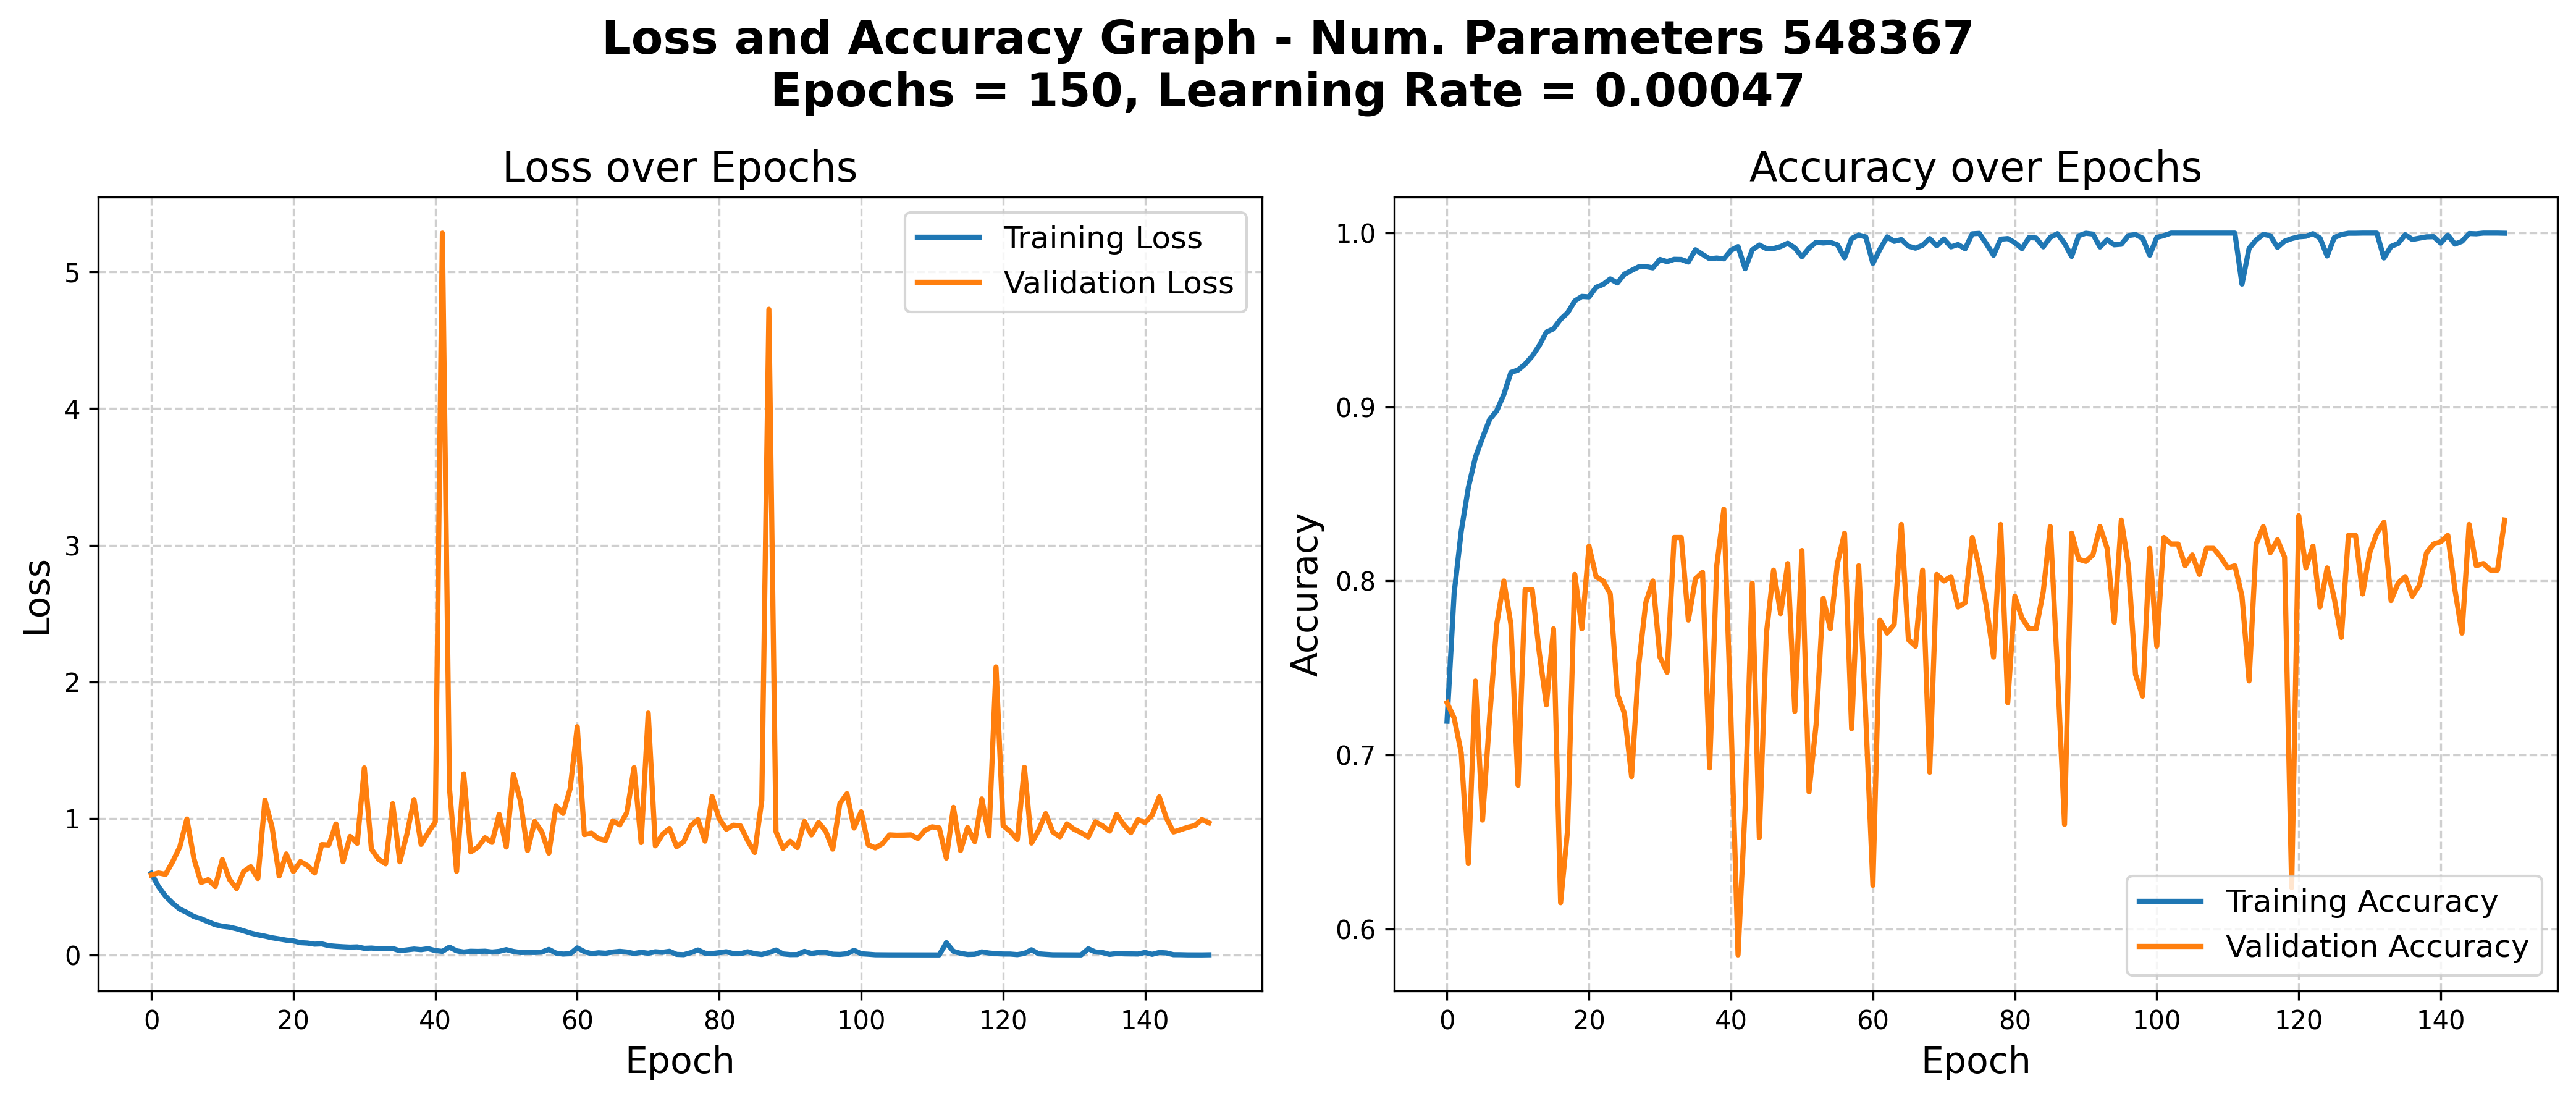

In [29]:
# LOSS AND ACCURACY GRAPH
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Crear figura con mayor calidad
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)

# Gráfico de pérdida (Loss)
axes[0].plot(loss, label='Training Loss', linewidth=2)
axes[0].plot(val_loss, label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=14)
axes[0].set_ylabel('Loss', fontsize=14)
axes[0].set_title('Loss over Epochs', fontsize=16)
axes[0].legend(fontsize=12)
axes[0].grid(True, linestyle="--", alpha=0.6)

# Gráfico de precisión (Accuracy)
axes[1].plot(accuracy, label='Training Accuracy', linewidth=2)
axes[1].plot(val_accuracy, label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].set_ylabel('Accuracy', fontsize=14)
axes[1].set_title('Accuracy over Epochs', fontsize=16)
axes[1].legend(fontsize=12)
axes[1].grid(True, linestyle="--", alpha=0.6)

# Título general con más claridad
plt.suptitle(f"Loss and Accuracy Graph - Num. Parameters {squeezenet_model.count_params()}\n"
             f"Epochs = {epochs}, Learning Rate = {new_learning_rate}",
             fontsize=18, fontweight='bold')

# Ajuste automático para evitar superposiciones
plt.tight_layout()

# Guardar la imagen en alta calidad
plt.savefig("training_metrics.png", dpi=300, bbox_inches="tight", format="png")

# Mostrar la gráfica
plt.show()

In [30]:
#Carga Mejor modelo
from keras.models import load_model
# Cargar el modelo guardado en "best_model.h5"
model = load_model('best_model_checkpoint/best_model_epoch_133.h5')

# Evaluación en el conjunto test
_, accuracy = squeezenet_model.evaluate(testMFCCs, testLabels)
print(f'Accuracy: {accuracy}')

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 2)

In [31]:
# Evaluación en el conjunto train
_, accuracy = squeezenet_model.evaluate(trainMFCCs, trainLabels)
print(f'Accuracy: {accuracy}')

375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.9999 - loss: 5.3955e-04
Accuracy: 0.999666690826416


In [32]:
#Exporta el modelo
#export_dir = 'CNN_Python/saved_models/modelo_tesis_binario_Angry_finalv5'
# tf.saved_model.save(model, export_dir)
#tf.keras.models.save_model(model, export_dir)

export_dir = 'saved_models/modelo_tesis_binario_Angry_finalv5/saved_modelSqueezeNet.keras'
tf.keras.models.save_model(squeezenet_model, export_dir)

In [33]:
#Define Umbral
umbral = 0.5
#Predice probabilidades de las clases (de 0 a 1)
predict = squeezenet_model.predict(evalMFCCs)
# Aplica el umbral para convertir las predicciones en 0 o 1
Label_predict = (predict > umbral).astype(int)
#Dimenciones de vector de etiquetas
print("Dimensiones de vector de etiquetas: ", Label_predict.shape)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Dimensiones de vector de etiquetas:  (800, 2)


In [34]:
#Calcula matriz de confusión
con_mat = confusion_matrix(evalLabels, Label_predict, labels=clases_vec)
#Convierte matriz en un pandas dataframe
#Rows =    Valores verdaderos
#Columns = Valores predichos
con_mat_df = pd.DataFrame(con_mat, index=emotion_vec, columns=emotion_vec)

# Crear un mapa de calor con mayor calidad
plt.figure(figsize=(10, 8), dpi=300)
sns.heatmap(con_mat_df, annot=True, fmt='d', cmap='Blues', 
            linewidths=0.5, annot_kws={'size': 12, 'color': 'black'})

# Etiquetas y título mejorados
plt.xlabel('Prediction', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')

# Mostrar la gráfica
plt.show()

ValueError: multilabel-indicator is not supported

In [35]:
# Evaluación en el conjunto de validación
_, accuracy = squeezenet_model.evaluate(evalMFCCs, evalLabels)

print(f'Accuracy: {accuracy}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8312 - loss: 0.8199
Accuracy: 0.8349999785423279


In [36]:
# TABLA

import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

# Assume you have defined your MiniVGG16 model and it's stored in the variable `model`
# model = MiniVGG16(...) 


# Calculate the total number of parameters in the model
total_params = squeezenet_model.count_params()

# Heuristic to determine computational complexity based on parameter count
if total_params < 1e6:
    model_complexity = "Baja"   # Low complexity
elif total_params < 1e7:
    model_complexity = "Media"  # Medium complexity
else:
    model_complexity = "Alta"   # High complexity

# Define model name
model_name = "SqueezeNet"

# Crea lista vacía de estadísticos
statistics = []

# Ciclo para calcular especificidad, recall, precision y f_score
for label in range(0, 2):
    precision, recall, f_score, support = precision_recall_fscore_support(
        evalLabels == label,
        Label_predict == label
    )
    # Se añade a cada registro:
    # [Nombre del modelo, emoción, especificidad, recall, precision, f_score, FLOPS, complejidad computacional]
    statistics.append([
        model_name,
        emotion_vec[label],
        recall[0],
        recall[1],
        precision[1],
        f_score[1],
        total_flops,
        model_complexity
    ])

# Convierte resultados en dataframe y agrega columnas
statistics = pd.DataFrame(statistics, columns=[
    "Model", "Emotion", "Specificity", "Recall", "Precision", "F_Score", "FLOPS", "Comp_Complexity"
])
statistics


,Model,Emotion,Specificity,Recall,Precision,F_Score,FLOPS,Comp_Complexity
0,SqueezeNet,Other,0.8125,0.8575,0.820574,0.838631,257964950,Baja
1,SqueezeNet,Angry,0.8575,0.8125,0.850785,0.831202,257964950,Baja


In [37]:
#CURVA ROC

fpr, tpr, umbrales = roc_curve(evalLabels, predict)
area_bajo_curva = roc_auc_score(evalLabels, predict)

# Mejora la calidad de la imagen
plt.figure(figsize=(10, 8), dpi=300)

# Graficar la Curva ROC
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {area_bajo_curva:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Línea de referencia

# Configuración de ejes y estilo
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('Specificity (Sp)', fontsize=14)
plt.ylabel('Sensibility (Sen)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')

# Agregar cuadrícula
plt.grid(True, linestyle='--', alpha=0.6)

# Mostrar leyenda
plt.legend(loc='lower right', fontsize=12)

# Mostrar la gráfica
plt.show()

ValueError: multilabel-indicator format is not supported